# Transfer Learning Implementation (from the VGG16 pretrained model)

## Purpose

The purpose of this notebook is to classify between pictures of ants and bees using transfer learning from the VGG16 pretrained model.

## Imports

In [0]:
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import PIL.ImageOps
from torch import nn
from torchvision import datasets, transforms, models
from tqdm import tqdm

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
!git clone https://github.com/jaddoescad/ants_and_bees

fatal: destination path 'ants_and_bees' already exists and is not an empty directory.


In [0]:
!ls

ants_and_bees  sample_data


In [0]:
!ls ants_and_bees/

train  val


In [0]:
!ls ants_and_bees/train/

ants  bees


In [0]:
!ls ants_and_bees/train/ants/

 0013035.jpg		     408393566_b5b694119b.jpg
 1030023514_aad5c608f9.jpg   424119020_6d57481dab.jpg
 1095476100_3906d8afde.jpg   424873399_47658a91fb.jpg
 1099452230_d1949d3250.jpg   450057712_771b3bfc91.jpg
 116570827_e9c126745d.jpg    45472593_bfd624f8dc.jpg
 1225872729_6f0856588f.jpg   459694881_ac657d3187.jpg
 1262877379_64fcada201.jpg   460372577_f2f6a8c9fc.jpg
 1269756697_0bce92cdab.jpg   460874319_0a45ab4d05.jpg
 1286984635_5119e80de1.jpg   466430434_4000737de9.jpg
 132478121_2a430adea2.jpg    470127037_513711fd21.jpg
 1360291657_dc248c5eea.jpg   474806473_ca6caab245.jpg
 1368913450_e146e2fb6d.jpg   475961153_b8c13fd405.jpg
 1473187633_63ccaacea6.jpg   484293231_e53cfc0c89.jpg
 148715752_302c84f5a4.jpg    49375974_e28ba6f17e.jpg
 1489674356_09d48dde0a.jpg   506249802_207cd979b4.jpg
 149244013_c529578289.jpg    506249836_717b73f540.jpg
 150801003_3390b73135.jpg    512164029_c0a66b8498.jpg
 150801171_cd86f17ed8.jpg    512863248_43c8ce579b.jpg
 154124431_65460430f2.jpg    518773929_7

## Preprocessing the image data from local images

Transformations used:

- ToTensor will convert the numpy array with pixel brightness values ranging from 0-255 (which is the structure the images in the dataset are currently in) to a float tensor with pixel brightness values ranging from 0-1

- Normalize will apply normalization to the pixel brightness values (subtract value from mean and then divide by the standard deviation). This makes convergence to minumum loss quicker.

- Data augmentation will change the images in random ways (rotations, shear, etc..) to introduce more diversification into the training data. This should help prevent overfitting. 



In [0]:
transform = transforms.Compose([
                               transforms.Resize((224,224)), # we do this resizing since the pretrained VGG16 model was trained on images that were 224x224 so we have to convert ours so it is compatiable with our pretrained model.
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                               ]) # defining the transformations we want to make to the images before feeding them into our model

transform_train_augmented = transforms.Compose([
                               transforms.Resize((224,224)), # we do this resizing since the pretrained VGG16 model was trained on images that were 224x224 so we have to convert ours so it is compatiable with our pretrained model.
                               transforms.RandomHorizontalFlip(), # data augmentation
                               transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)), # data augmentation
                               transforms.ColorJitter(brightness=1, contrast=1, saturation=1), # data augmentation
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                               ]) # defining the transformations we want to make to the images before feeding them into our model

training_dataset = datasets.ImageFolder('ants_and_bees/train', transform=transform_train_augmented)
validation_dataset = datasets.ImageFolder('ants_and_bees/val', transform=transform)

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 20, shuffle=True) # create a dataloader to handle batching of the data. Note that we shuffle the data at each epoch to prevent the gradient descent process from getting stuck in a local minimum, we want it to reach the absolute minimum.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)

In [0]:
print(len(training_dataset))
print(len(validation_dataset))

244
153


In [0]:
classes = ['ant', 'bee']

## Plotting the original training images

In [0]:
def image_convert(tensor): # all this function does is prepeare the images for plotting by changing them from tensors to numpy arrays and also reversing the transforms made when creating training_dataset
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

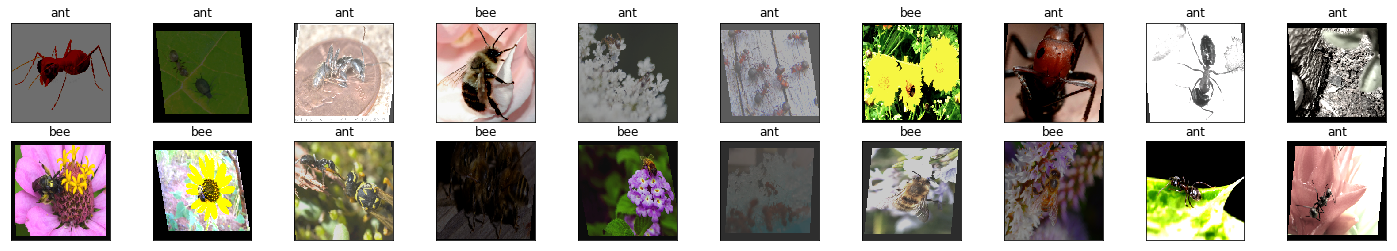

In [0]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  axis = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
  plt.imshow(image_convert(images[idx]))
  axis.set_title(classes[labels[idx].item()])
  

## Building the model

In [0]:
model = models.vgg16(pretrained=True) # loading the pretrained VGG16 model from PyTorch (it was pretrained on ImageNet)

In [0]:
print(model) # The model has 13 convolutional layers (each followed by a ReLu activation), 5 pooling layers, as well as 3 fully connected layers. 
             # There are also dropout layers inbetween the fully connected layers since they have a large number of parameters  

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
for param in model.features.parameters(): # this loop "freezes" the feature extraction part of our model (the CNN layers) so that it is not changed during training on our small dataset. All we want to train is the fully connected (classification) layers. 
  param.requires_grad = False             # Note that requires_grad = False        

In [0]:
# the purpose of the following cell is to change the 6th layer in the classifer section of the model to have 2 output classes instead of 1000 since we are only classifying betweens ants and bees, not the 1000 classes that are part of ImageNet

n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)

print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [0]:
criterion = nn.CrossEntropyLoss() # we use Cross Entropy Loss for the loss function since it is a multi-class problem. Remember that this function also implicitly applies the log_softmax activation function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # We use Adam as our optimizer

## Training the model

In [0]:
epochs = 5
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

def train():
  for e in tqdm(range(epochs)):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs, 1) # gets the prediction of the model
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data) # counts the number of images classified correctly by comparing the prediction to the corresponding label

    else: # this block of code is executed after all of the iterations (end of an epoch)
      with torch.no_grad(): # this will set requires_grad = False for the tensors since no gradients need to be taken in this step. This is done to save memory. 
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)
          
          _, val_preds = torch.max(val_outputs, 1) # gets the prediction of the model
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data) # counts the number of images classified correctly by comparing the prediction to the corresponding label
        
      epoch_loss = running_loss/len(training_loader.dataset) # average loss for each epoch
      epoch_accuracy = running_corrects.float()/len(training_loader.dataset) # accuracy for each epoch
      running_loss_history.append(epoch_loss)
      running_corrects_history.append(epoch_accuracy)
      
      val_epoch_loss = val_running_loss/len(validation_loader.dataset) # average loss for each epoch
      val_epoch_accuracy = val_running_corrects.float()/len(validation_loader.dataset) # accuracy for each epoch
      val_running_loss_history.append(val_epoch_loss)
      val_running_corrects_history.append(val_epoch_accuracy)
      
      print("")
      print("Epoch #{}".format(e+1))
      print("Training loss: {:.4f}, Training Accuracy: {:.4f}".format(epoch_loss, epoch_accuracy.item()))
      print("Validation loss: {:.4f}, Validation Accuracy: {:.4f}".format(val_epoch_loss, val_epoch_accuracy.item()))

    

In [0]:
train()

 20%|██        | 1/5 [00:06<00:25,  6.36s/it]


Epoch #1
Training loss: 0.0325, Training Accuracy: 0.6393
Validation loss: 0.0116, Validation Accuracy: 0.9216


 40%|████      | 2/5 [00:12<00:19,  6.34s/it]


Epoch #2
Training loss: 0.0188, Training Accuracy: 0.8156
Validation loss: 0.0132, Validation Accuracy: 0.9216


 60%|██████    | 3/5 [00:18<00:12,  6.33s/it]


Epoch #3
Training loss: 0.0162, Training Accuracy: 0.8525
Validation loss: 0.0140, Validation Accuracy: 0.9281


 80%|████████  | 4/5 [00:25<00:06,  6.33s/it]


Epoch #4
Training loss: 0.0143, Training Accuracy: 0.8730
Validation loss: 0.0135, Validation Accuracy: 0.9281


100%|██████████| 5/5 [00:31<00:00,  6.32s/it]


Epoch #5
Training loss: 0.0119, Training Accuracy: 0.9016
Validation loss: 0.0174, Validation Accuracy: 0.8954


## Plotting (and analyzing) the results

In [0]:
def plot_losses():
  plt.plot(running_loss_history, label="Training loss")
  plt.plot(val_running_loss_history, label="Validation loss")
  plt.legend()

In [0]:
def plot_accuracy():
  plt.plot(running_corrects_history, label ="Training accuracy")
  plt.plot(val_running_corrects_history, label ="Validation accuracy")
  plt.legend()

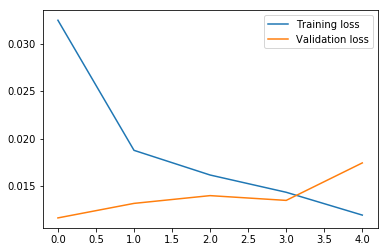

In [0]:
plot_losses() # here we notice it is just starting to overfit.

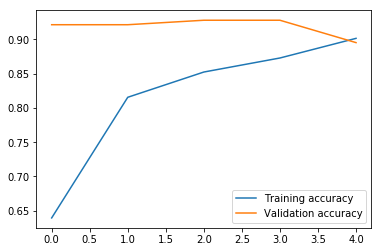

In [0]:
plot_accuracy()

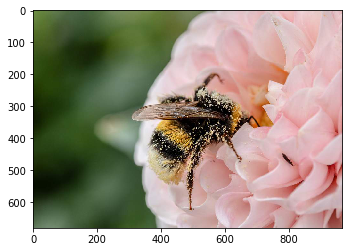

In [0]:
import requests
from PIL import Image

url = 'https://static.independent.co.uk/s3fs-public/thumbnails/image/2019/04/05/10/bee-rose.jpg?w968h681'
response = requests.get(url, stream = True)
img = Image.open(response.raw)

plt.imshow(img)

We must apply some preprocessing to this image so that it can be classified by our model:

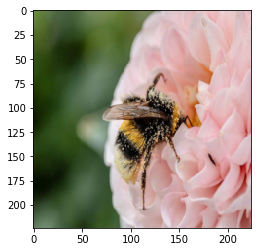

In [0]:
img = transform(img)
plt.imshow(image_convert(img)) # we have to convert the image back to a numpy array for plt.imshow to render the image

In [0]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1) # gets the prediction of the model
print("Prediction is: {}".format(classes[pred.item()]))

Prediction is: bee


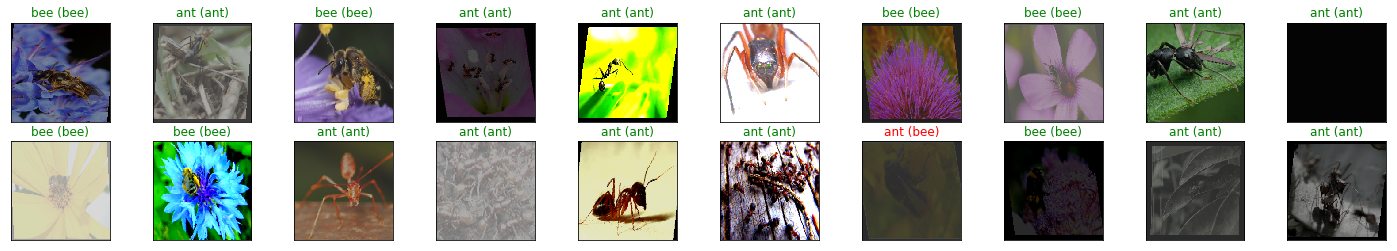

In [0]:
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))